# Dogs vs Cats Image Classification Without Image Augmentation

We'll build an image classifier using `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`.



# Importing packages

Let's start by importing required packages:

*   os — to read files and directory structure
*   numpy — for some matrix math outside of TensorFlow
*   matplotlib.pyplot — to plot the graph and display images in our training and validation data


In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Data Loading

We will make use of the class `tf.keras.preprocessing.image.ImageDataGenerator` which will read data from disk. We therefore need to directly download *Dogs vs. Cats* from a URL and unzip it.

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68606236/68606236 [==============================] - 1s 0us/step


The dataset we have downloaded has the following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

We can list the directories with the following terminal command:

In [6]:
zip_dir_base = os.path.dirname(zip_dir)
print(os.listdir(zip_dir_base))
!find $zip_dir_base -type d -print

['cats_and_dogs_filtered', 'cats_and_dogs_filterted.zip']
/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats


We'll now assign variables with the proper file path for the training and validation sets.

In [7]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
print(base_dir,"\n", train_dir,"\n",validation_dir)

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

/root/.keras/datasets/cats_and_dogs_filtered 
 /root/.keras/datasets/cats_and_dogs_filtered/train 
 /root/.keras/datasets/cats_and_dogs_filtered/validation


### Understanding our data

Let's look at how many cats and dogs images we have in our training and validation directory

In [8]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [9]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Setting Model Parameters

For convenience, we'll set up variables that will be used later while pre-processing our dataset and training our network.

In [10]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

# Data Preparation

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

We can set this up in a couple of lines of code.

In [11]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk, apply rescaling, and resize them using single line of code.

In [12]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [13]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### Visualizing Training images

We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using `matplotlib`.

In [14]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset. One batch is a tuple of (*many images*, *many labels*). For right now, we're discarding the labels because we just want to look at the images.

In [15]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

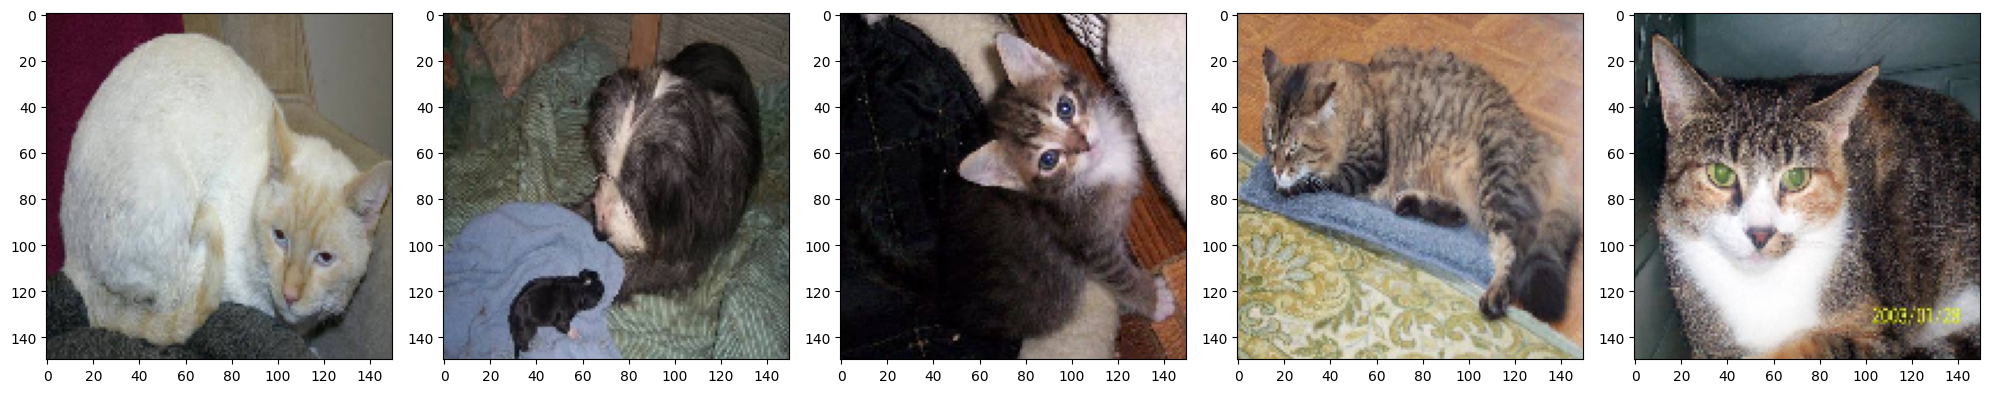

In [16]:
plotImages(sample_training_images[:5])  # Plot images 0-4

# Model Creation

## Define the model

The model consists of four convolution blocks with a max pool layer in each of them. Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`.

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

### Compile the model

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `sparse_categorical_crossentropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model Summary

Let's look at all the layers of our network using **summary** method.

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

### Train the model

It's time we train our network.

Since our batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`.

In [20]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

<ipython-input-20-d70e0a339f06>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
20/20 [==============================] - 12s 262ms/step - loss: 0.7081 - accuracy: 0.5125 - val_loss: 0.6916 - val_accuracy: 0.5020
Epoch 2/100
20/20 [==============================] - 6s 305ms/step - loss: 0.6879 - accuracy: 0.5630 - val_loss: 0.6721 - val_accuracy: 0.5240
Epoch 3/100
20/20 [==============================] - 5s 257ms/step - loss: 0.6596 - accuracy: 0.6000 - val_loss: 0.6607 - val_accuracy: 0.6040
Epoch 4/100
20/20 [==============================] - 6s 293ms/step - loss: 0.6488 - accuracy: 0.6150 - val_loss: 0.6258 - val_accuracy: 0.6520
Epoch 5/100
20/20 [==============================] - 6s 285ms/step - loss: 0.5844 - accuracy: 0.7055 - val_loss: 0.5923 - val_accuracy: 0.6860
Epoch 6/100
20/20 [==============================] - 5s 249ms/step - loss: 0.5492 - accuracy: 0.7180 - val_loss: 0.6119 - val_accuracy: 0.6580
Epoch 7/100
20/20 [==============================] - 5s 256ms/step - loss: 0.5241 - accuracy: 0.7480 - val_loss: 0.5601 - val_accuracy: 0.717

### Visualizing results of the training

We'll now visualize the results we get after training our network.

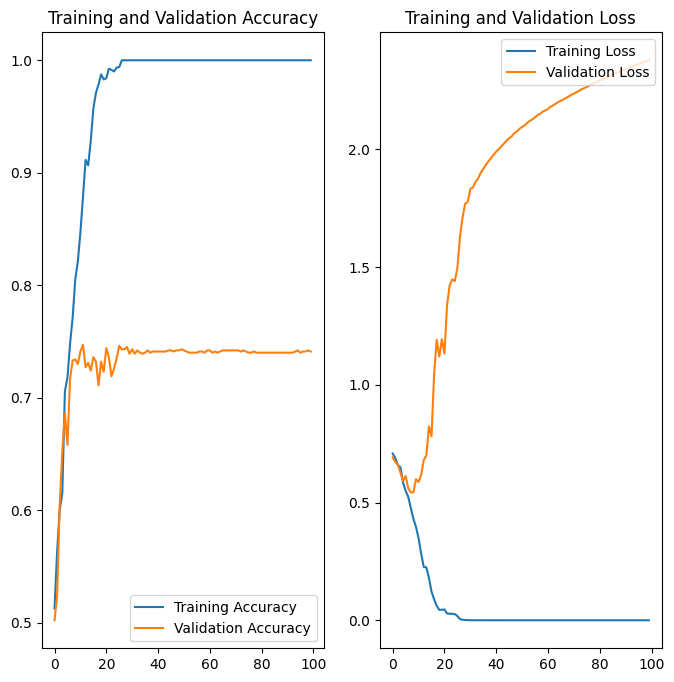

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

As we can see from the plots, training accuracy and validation accuracy are off by large margin and our model has achieved only around **70%** accuracy on the validation set (depending on the number of epochs you trained for).

This is a clear indication of overfitting. Once the training and validation curves start to diverge, our model has started to memorize the training data and is unable to perform well on the validation data.